### Necessary Imports and Installs

In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, BatchNormalization, Dropout, Flatten, Lambda, Input, Activation
from tensorflow.keras.callbacks import Callback, TensorBoard as TensorboardCallback, EarlyStopping
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from huggingface_hub import notebook_login, HfFolder, HfApi
import utils
from utils import data_loader
from utils import custom_generators
from utils import visualization
from utils.augmentation import data_augmentation_transformer, data_augmentation_cnn

import numpy as np
import matplotlib.pyplot as plt
import time
import opendatasets as od
import warnings

from importlib import reload

import logging
from GLC.data_loading.common import load_patch

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys
import time
import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Setting environment variables
hours = 4

tf.random.set_seed(42)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./geolifeclef-2022-lifeclef-2022-fgvc9/")

warnings.filterwarnings('ignore')

# Set-up Tensorboard
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

# Choose pre-trained transformer
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
    keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [3]:
# Login to HuggingFace
# notebook_login()

### GPU Parallelization:

In [4]:
# The maximun value for num_threads is dependent on amount of CPU cores:
# amount of CPU cores * vCPUs to core ratio = theoretical max of NUM_THREADS
NUM_THREADS = 64

# The more batches we prefetch, the less idle the GPUs will be. 
# To check GPU usage:
# 1. Run nvidia-smi -l 1 from the terminal to monitor the GPU usage during training. 
# 2. Try to get close to 100% for all GPUs by adjusting the value below (and the two above). Due to the overhead
#    from tf.distribute.MirroredStrategy(), you won't be able to consistently get 100% for all GPUs. But try to 
#    get close.
# 3. Be aware that RAM limits the amount of batches you can prefetch.
PRE_FETCH_NUM_BATCHES = int(NUM_THREADS * 20) 

In [5]:
# Apply DATA Auto-sharding policy
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

In [6]:
# for distributed training (that is, using multiple GPUs for data parallelization)
# https://www.tensorflow.org/guide/distributed_training#use_tfdistributestrategy_with_keras_modelfit
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


# Dataset Creation

## Load Image Data

In [7]:
NUM_CLASSES = 30

In [8]:
reload(utils.data_loader)
loader = data_loader.DataLoader(data_path="./geolifeclef-2022-lifeclef-2022-fgvc9/")

train_ids, y_train, val_ids, y_val, test_ids, y_test = loader.subset_labels_dense(num_labels=NUM_CLASSES, min_obs=1000, max_obs=2000)

In [9]:
from sklearn.utils import shuffle 
train_ids, y_train = shuffle(train_ids, y_train)

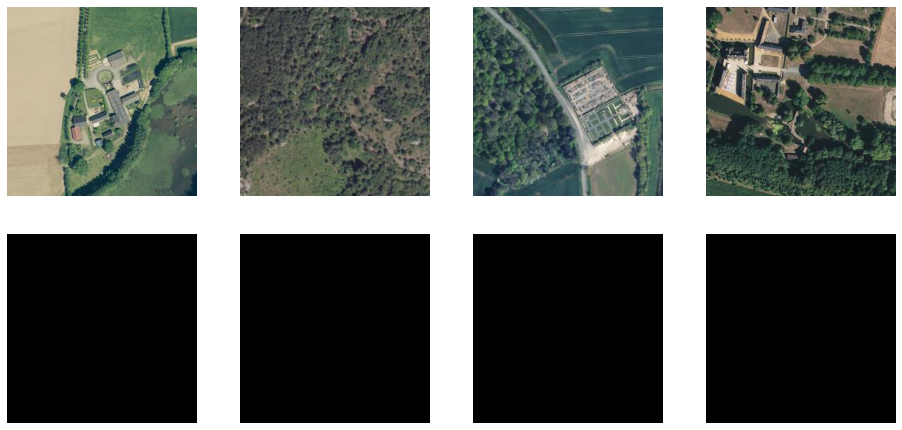

In [10]:
# Used to set image_size based on chosen transformer
visualization.visualize_augmentation(train_ids, DATA_PATH, num_images=4, contrast=0.2, flip='horizontal', rotation=0.3)

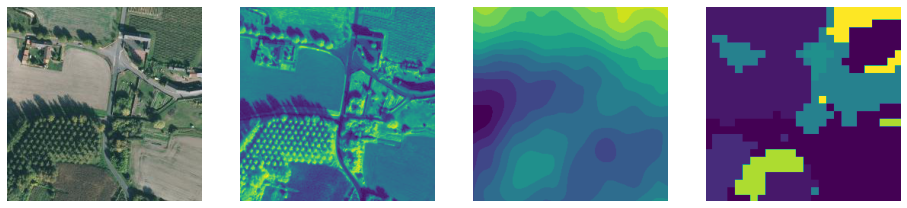

In [11]:
visualization.visualize_sat(train_ids, image=45, data_path=DATA_PATH)

## Load Tabular Data

In [12]:
df_train, df_val, df_test = loader.load_environmental_data(train_ids, val_ids, test_ids)

In [13]:
# Impute all missing values to calculate accurate loss
from sklearn.impute import SimpleImputer

# impute train data
imputer = SimpleImputer()
column_names = df_train.columns.values
row_names = df_train.index.values

df_imp_train = pd.DataFrame(imputer.fit_transform(df_train))
df_imp_train.index = row_names
df_imp_train.columns = column_names

# impute val data
row_names = df_val.index.values

df_imp_val = pd.DataFrame(imputer.transform(df_val))
df_imp_val.index = row_names
df_imp_val.columns = column_names

# Do not impute test data, instead drop nan rows
drop_idx = df_test.iloc[list(pd.isnull(df_test).any(1).values.nonzero()[0])].index.values
test_ids_temp = []
y_test_temp = []
for i, el in enumerate(zip(test_ids, y_test)):
    idx, label = el
    if idx not in drop_idx:
        test_ids_temp.append(idx)        
        y_test_temp.append(label)

test_ids = np.array(test_ids_temp)
y_test = np.array(y_test)

df_test = df_test.dropna()

In [14]:
# Assign numeric token for embedding (-200 because it never appears in the data - heuristic)
# sep = -200
# input_cells = df_imp_train.assign(token=sep)
# val_cells = df_imp_val.assign(token=sep)
# test_cells = df_test.assign(token=sep)

input_cells = df_imp_train
val_cells = df_imp_val
test_cells = df_test

In [15]:
# input_cells = np.array(input_cells).reshape(len(input_cells), len(input_cells.columns), 1)
# val_cells = np.array(val_cells).reshape(len(val_cells), len(val_cells.columns), 1)
# test_cells = np.array(test_cells).reshape(len(test_cells), len(test_cells.columns), 1)

In [16]:
# # Check that all nan are removed
assert sum(sum(np.isnan(np.array(input_cells)))) == 0
assert sum(sum(np.isnan(np.array(val_cells)))) == 0
assert sum(sum(np.isnan(np.array(test_cells)))) == 0

# Build Pre-trained Transformer

## Training function

In [17]:
def run_experiment(model, train_ds, y_train, val_ds, y_val, test_ds, y_test, batch_size, eval_batch_size, num_epochs=10, ds_reps_per_epoch=1):
    callbacks = []
    
    checkpoint_filepath = "models/{}".format(model._name)
    callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=True,
                                     save_weights_only=False, 
                                     mode='min', 
                                     save_freq='epoch'))
        
    log_dir = "logs/fit/{}-".format(model._name) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks.append(keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))
    callbacks.append(keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)) 

    csv_dir = "{}.csv".format(model._name)
    callbacks.append(tf.keras.callbacks.CSVLogger(csv_dir))

    history = model.fit(
        train_ds.shuffle(batch_size).repeat(),
        steps_per_epoch=np.floor(len(y_train)/batch_size) * ds_reps_per_epoch,
        validation_data=val_ds.repeat(),
        validation_steps=np.floor(len(y_val)/eval_batch_size),
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        max_queue_size=PRE_FETCH_NUM_BATCHES, 
        workers=NUM_THREADS, 
        use_multiprocessing=True
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_ds,
                                                 batch_size=batch_size,
                                                 steps=np.floor(len(y_test)/eval_batch_size)-1,
                                                 max_queue_size=PRE_FETCH_NUM_BATCHES,
                                                 workers=NUM_THREADS,
                                                 use_multiprocessing=True)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [18]:
# multi-layer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Creating Model Architecture

In [50]:
from transformers import TFViTModel, TFViTForImageClassification, ViTFeatureExtractor

def vit(model_id, input_shape, learning_rate, num_classes, weight_decay_rate, num_channels=3):          
    # for distributed training
    with mirrored_strategy.scope():
        from transformers import ViTModel, ViTConfig

        # Initializing a ViT vit-base-patch16-224 style configuration and reducing size
        config = ViTConfig(hidden_size = 768,
                           num_hidden_layers = 6,
                           num_attention_heads = 6,
                           intermediate_size = 3072,
                           hidden_act = 'gelu',
                           hidden_dropout_prob = 0.0,
                           attention_probs_dropout_prob = 0.0,
                           initializer_range = 0.02,
                           layer_norm_eps = 1e-12,
                           is_encoder_decoder = False,
                           image_size = 224,
                           patch_size = 16,
                           num_channels = 3)
        
        # load pre-trained ViT model
        base_model = TFViTModel.from_pretrained(model_id, config=config)
        feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
        
        # Inputs
        inputs = layers.Input(shape=input_shape, name='rgb_input', dtype='float32')

        # Augment data
        augmented = data_augmentation_transformer(output_size=feature_extractor.size)(inputs)

        # Pre-trained ViT model
        vit = base_model(augmented)[0]
       
        # Add MLP.
        features = mlp(vit[:, 0, :], hidden_units=mlp_head_units, dropout_rate=0.5)

        # Classify outputs.
        logits = layers.Dense(num_classes)(features)

        # Create the Keras model.
        model = tf.keras.Model(inputs=inputs, outputs=logits)

        # Optimizer
        optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, 
                                         weight_decay=weight_decay_rate)
        # Compile model
        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
    
        return model

### ViT with RGB pretrained only on ImageNet

In [51]:
batch_size = 128
eval_batch_size = 16

In [52]:
# Create TF Dataset
train_data = custom_generators.RGBImageGenerator(train_ids, y_train, batch_size, DATA_PATH)
val_data = custom_generators.RGBImageGenerator(val_ids, y_val, eval_batch_size, DATA_PATH)
test_data = custom_generators.RGBImageGenerator(test_ids, y_test, eval_batch_size, DATA_PATH)
# converting our train dataset to tf.data.Dataset
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = (tf.float16 , tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = (tf.float16 , tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = (tf.float16 , tf.float16))
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [ ]:
# Create model
model_id = "google/vit-base-patch16-224-in21k"

vit_rgb_imagenet = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001
             )

vit_rgb_imagenet._name = 'vit-rgb-pretrained-imagenet'

# Run training
vit_rgb_imagenet_results = run_experiment(model=vit_rgb_imagenet,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTModel: ['vit/encoder/layer_._8/attention/attention/key/bias:0', 'vit/encoder/layer_._11/output/dense/bias:0', 'vit/encoder/layer_._9/output/dense/bias:0', 'vit/encoder/layer_._10/attention/attention/value/bias:0', 'vit/encoder/layer_._6/intermediate/dense/bias:0', 'vit/encoder/layer_._9/attention/attention/value/bias:0', 'vit/encoder/layer_._11/attention/output/dense/kernel:0', 'vit/encoder/layer_._11/layernorm_before/gamma:0', 'vit/encoder/layer_._7/output/dense/bias:0', 'vit/encoder/layer_._6/intermediate/dense/kernel:0', 'vit/encoder/layer_._10/layernorm_after/gamma:0', 'vit/encoder/layer_._7/attention/attention/value/bias:0', 'vit/encoder/layer_._11/layernorm_after/gamma:0', 'vit/encoder/layer_._7/intermediate/dense/kernel:0', 'vit/encoder/layer_._9/attention/attention/key/bias:0', 'vit/encoder/layer_._8/attention/attention/query/kernel:0', 'vit/encoder/layer_._10/attenti

Epoch 1/50


In [ ]:
# api = HfApi()

# user = api.whoami(hub_token)

# feature_extractor.save_pretrained(output_dir)

# api.upload_file(
#     token=hub_token,
#     repo_id=f"{user['name']}/{hub_model_id}",
#     path_or_fileobj=os.path.join(output_dir,"preprocessor_config.json"),
#     path_in_repo="preprocessor_config.json",
# )

In [ ]:
vit_rgb_imagenet.summary()

In [ ]:
reload(utils.visualization)
visualization.plot_training_results(vit_rgb_imagenet_results, top_k=5)

### ViT only with RGB Images on EuroSat

In [ ]:
# Create model
model_id = "philschmid/vit-base-patch16-224-in21k-euroSat"

vit_rgb_eurosat = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001
             )

vit_rgb_eurosat._name = 'vit-rgb-pretrained-euroSat'

In [ ]:
vit_rgb_eurosat_results = run_experiment(model=vit_rgb_eurosat,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

In [ ]:
visualization.plot_training_results(vit_rgb_eurosat_results)

In [ ]:
vit_rgb_eurosat.summary()

### ViT with all Satellite Image Data

In [ ]:
# generate data using all types of data for an observation
train_data = custom_generators.FullSatelliteGenerator(train_ids, y_train, batch_size, DATA_PATH)
val_data = custom_generators.FullSatelliteGenerator(val_ids, y_val, eval_batch_size, DATA_PATH)
test_data = custom_generators.FullSatelliteGenerator(test_ids, y_test, eval_batch_size, DATA_PATH)
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = (tf.float16 , tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = (tf.float16 , tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = (tf.float16 , tf.float16))
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [ ]:
model_id = "philschmid/vit-base-patch16-224-in21k-euroSat"

vit_sat = vit(model_id, 
                      input_shape=(256, 256, 3), 
                      learning_rate=3e-4, 
                      num_classes=NUM_CLASSES, 
                      weight_decay_rate=0.0001
                     )

vit_sat._name = 'vit-all-sat-pretrained-euroSat'

vit_sat_results = run_experiment(model=vit_sat,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

In [ ]:
visualization.plot_training_results(vit_sat_results)

In [ ]:
vit_sat.summary()

### ViT all Sat EuroSat Channels=6

In [ ]:
# generate data using all types of data for an observation
train_data = custom_generators.FullSatelliteGeneratorChannels(train_ids, y_train, batch_size, DATA_PATH)
val_data = custom_generators.FullSatelliteGeneratorChannels(val_ids, y_val, eval_batch_size, DATA_PATH)
test_data = custom_generators.FullSatelliteGeneratorChannels(test_ids, y_test, eval_batch_size, DATA_PATH)
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = (tf.float16 , tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = (tf.float16 , tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = (tf.float16 , tf.float16))
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [ ]:
model_id = "philschmid/vit-base-patch16-224-in21k-euroSat"

vit_sat_ch = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001,
              num_channels=6
             )

vit_sat_ch._name = 'vit-all-sat-pretrained-euroSat'

vit_sat_ch_results = run_experiment(model=vit_sat,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

In [ ]:
visualization.plot_training_results(vit_sat_results)

In [ ]:
vit_sat_ch.summary()

# Multimodal ViT From Scratch

In [ ]:
learning_rate = 0.0001
weight_decay = 0.001
batch_size = 32
eval_batch_size = 8
num_epochs = 50
image_size = 144  # We'll resize input images to this size (smaller than in other ViT to prevent overfitting)
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
input_shape = (256, 256, 3)
num_cols = input_cells.shape[1]
projection_dim = 64
num_heads = 6
num_classes = NUM_CLASSES
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
# Patch creation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
        })
        return config
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.type_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection": self.projection,
            "position_embedding": self.position_embedding,
            "type_embedding": self.type_embedding,
        })
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        type_token = 0 # add type token for image
        encoded = self.projection(patch) + self.position_embedding(positions) + self.type_embedding(type_token)
        return encoded
    
class NumericEncoder(layers.Layer):
    def __init__(self, num_cols, projection_dim):
        super(NumericEncoder, self).__init__()
        self.num_cols = num_cols
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        self.type_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_cols": self.num_cols,
            "projection": self.projection,
            "position_embedding": self.position_embedding,
            "type_embedding": self.type_embedding,
        })
        return config

    def call(self, cell):
        positions = tf.range(start=0, limit=self.num_cols, delta=1)
        type_token = 1 # add type token for numeric
        encoded = self.projection(cell) + self.position_embedding(positions) + self.type_embedding(type_token)
        return encoded

In [ ]:
# # Visualize patches
# plt.figure(figsize=(4, 4))
# image = np.asarray(load_patch(train_ids[10], DATA_PATH, data='rgb')).reshape(256, 256, 3)
# plt.imshow(image.astype("uint8"))
# plt.axis("off")

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(image_size, image_size)
# )
# patches = Patches(patch_size)(resized_image)
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")

In [ ]:
def create_vit_classifier():
    with mirrored_strategy.scope():
        input_patches = layers.Input(shape=input_shape, name='input_1')
        input_cells = layers.Input(shape=(num_cols, 1), name='input_2')
         # Augment data.
        augmented = data_augmentation_cnn(output_size=image_size)(input_patches)
        # Create patches.
        patches = Patches(patch_size)(augmented)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # Output = (Number of patches, projection dimension)
        # Encode columns
        encoded_cells = NumericEncoder(num_cols, projection_dim)(input_cells) # Output = (Number of columns, projection dimension)

        # Concatenate patches and column embeddings with <SEP> token
        embeddings = layers.Concatenate(axis=1)([encoded_patches, encoded_cells]) # Output (#patches + #columns, projection dimension)    

        # Create multiple layers of the Transformer block.
        for _ in range(transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon=1e-6)(embeddings)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, embeddings])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
            # Skip connection 2.
            embeddings = layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(embeddings)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)

        # Add MLP.
        features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

        # Classify outputs.
        logits = layers.Dense(num_classes)(features)
        # Create the Keras model.
        model = keras.Model(inputs=[input_patches, input_cells], outputs=logits)
        
        optimizer = tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )

        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
    
        return model

In [ ]:
multimodal_vit = create_vit_classifier()

In [ ]:
# multimodal_vit.summary()

In [ ]:
reload(utils.custom_generators)
train_data = custom_generators.MultimodalTransformerGenerator(train_ids, y_train, batch_size, DATA_PATH, input_cells)
val_data = custom_generators.MultimodalTransformerGenerator(val_ids, y_val, eval_batch_size, DATA_PATH, val_cells)
test_data = custom_generators.MultimodalTransformerGenerator(test_ids, y_test, eval_batch_size, DATA_PATH, test_cells)

# converting our train dataset to tf.data.Dataset
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
                                                
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [ ]:
multimodal_vit._name = 'multimodal_vit'

# Run training
multimodal_vit_results = run_experiment(model=multimodal_vit,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

In [ ]:
reload(utils.visualization)
visualization.plot_training_results(multimodal_vit_results)

In [ ]:
# data, label = None, None

# ds = tf_train_dataset.take(100)
# for i, el in enumerate(ds):
#     if i == 99:
#         data, label = el
#         image = data["input_1"]
#         cells = data["input_2"]
#         print(image.shape, cells.shape, label)

In [ ]:
# def get_output_of_all_layers(model, test_input):
#     output_of_all_layers = []

#     for count, layer in enumerate(model.layers):

#         # skip the input and augmentation layer
#         if count <= 1:
#             continue

#         intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer.name).output)
#         intermediate_output = intermediate_layer_model.predict(test_input)[0]
        
#         if np.isnan(intermediate_output).any():
#             print(layer.name)
#             print('Input:')
#             print(output_of_all_layers[-2])
#             print(output_of_all_layers[-2].shape)
#             print('Output:')
#             print(intermediate_output)
#             break

#         output_of_all_layers.append(intermediate_output)

#     return np.array(output_of_all_layers)

# # outputs = get_output_of_all_layers(vit, data)

# Multimodal ViT with All Satellite Data

In [36]:
learning_rate = 0.0001
weight_decay = 0.001
input_shape = (256, 256, 6)
projection_dim = 64
num_heads = 6

In [37]:
multimodal_vit = create_vit_classifier()

In [39]:
reload(utils.custom_generators)
train_data = custom_generators.MultimodalTransformerChannelsGenerator(train_ids, y_train, batch_size, DATA_PATH, input_cells)
val_data = custom_generators.MultimodalTransformerChannelsGenerator(val_ids, y_val, eval_batch_size, DATA_PATH, val_cells)
test_data = custom_generators.MultimodalTransformerChannelsGenerator(test_ids, y_test, eval_batch_size, DATA_PATH, test_cells)

# converting our train dataset to tf.data.Dataset
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
                                                
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [ ]:
multimodal_vit._name = 'multimodal_vit'

# Run training
multimodal_vit_results = run_experiment(model=multimodal_vit,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Epoch 1/50
 354/1041 [=========>....................] - ETA: 14:44 - loss: 3.5072 - accuracy: 0.0732 - top-5-accuracy: 0.2621

In [ ]:
reload(utils.visualization)
visualization.plot_training_results(multimodal_vit_results)

# BERT for Tabular Data

In [ ]:
# tabular_train = loader.rename_environmental_table(tabular_train)
# tabular_val = loader.rename_environmental_table(tabular_val)

In [ ]:
# sentences_train = data_loader.transform_table_to_sentences(tabular_train)
# sentences_val = data_loader.transform_table_to_sentences(tabular_val)

In [ ]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# BERT_ID = 'bert-base-uncased'

# tokenizer = BertTokenizer.from_pretrained(BERT_ID)

In [ ]:
# # encode text
# def tokenize(sentences, tokenizer, max_length):
#     input_ids, input_masks, input_segments = [], [], []
#     for sentence in sentences:
#         inputs = tokenizer.encode_plus(sentence, add_special_tokens = True, max_length = max_length, pad_to_max_length = True, truncation=True, return_attention_mask = True, return_token_type_ids = True)
#         input_ids.append(inputs['input_ids'])
#         input_masks.append(inputs['attention_mask'])
#         input_segments.append(inputs['token_type_ids'])
#     return np.asarray(input_ids, dtype = "int32"), np.asarray(input_masks, dtype = "int32"), np.asarray(input_segments, dtype = "int32")

# max_length = len(max(sentences_train, key = len))

# input_ids, input_masks, input_segments = tokenize(sentences_train, tokenizer, max_length)
# val_ids, val_input_masks, val_input_segments = tokenize(sentences_val, tokenizer, max_length)

In [ ]:
# from transformers import BertConfig

# def bert(model_id, learning_rate, num_classes, sentence_length=256):          
#     # for distributed training
#     with mirrored_strategy.scope():
#         # Configure BERT to train faster
#         config = BertConfig(dropout=0, attention_dropout=0)

#         # load pre-trained BERT model
#         base_model = TFBertForSequenceClassification.from_pretrained(model_id, config = config)

#         # Inputs        
#         input_ids_in = Input(shape=(sentence_length,), name='input_token', dtype=tf.int32)
#         input_masks_in = Input(shape=(sentence_length,), name='masked_token', dtype=tf.int32) 

#         # Bert Embedding
#         embedding_layer = base_model(input_ids_in, attention_mask=input_masks_in)[0]

#         # Add classification head
#         outputs = layers.Dense(num_classes, name='outputs', activation='softmax')(embedding_layer)

#         # Define inputs and outputs
#         model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

#         # Optimizer
#         optimizer = tf.optimizers.Adam(learning_rate=learning_rate)    
#         # Compile model
#         model.compile(optimizer=optimizer,
#                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                       metrics=[
#                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#                           tf.keras.metrics.SparseTopKCategoricalAccuracy(10, name="top-10-accuracy")
#                       ],
#                       )

#         return model

In [ ]:
# bert = bert(BERT_ID, LEARNING_RATE, NUM_CLASSES, sentence_length=max_length)

In [ ]:
# bert_input = [
#     input_ids,
#     input_masks
# ]

# bert_val = [
#     val_ids, 
#     val_input_masks
# ]

# # need to use SGD to not exceed GPU memory
# bert_results = bert.fit(
#     x=bert_input,
#     y=y_train,
#     batch_size=2,
#     validation_data=(bert_val, y_val),
#     epochs=20,
#     callbacks=callbacks,
#     workers=NUM_THREADS, 
#     use_multiprocessing=True
# )

In [ ]:
# plot_training_results(bert_results)